This notebook was created to convert the original VQC notebook to follow the routines of the new Qiskit version.

In [1]:
import logging
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import qiskit
from qiskit import IBMQ, Aer, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.algorithms.classifiers import VQC, NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.datasets import breast_cancer

# provider = IBMQ.load_account() # Load account to use cloud-simulator.
from IPython.display import clear_output

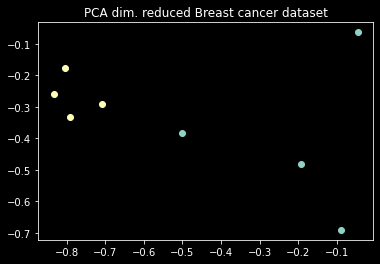

In [10]:
# Load data. PCA reduced to four dimensions.
Xtrain, Ytrain, Xtest, Ytest = breast_cancer(training_size=4,
                                            test_size=40, n = 4, plot_data=True)

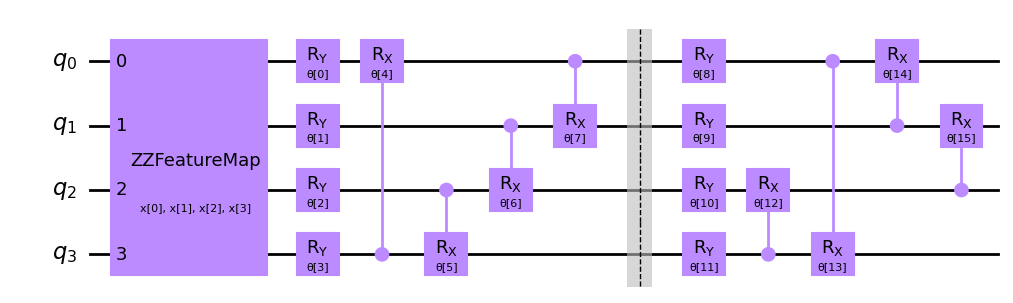

In [120]:
# We create the feature map and ansatz to be used.
feature_map = ZZFeatureMap(4, reps=2, 
                           entanglement="linear") # Our data is two dimensional, hence, two qubits.

parameters = ParameterVector('θ', 16)
ansatz = QuantumCircuit(4)
for i in range(4):
    ansatz.ry(parameters[i], i)
    
ansatz.crx(parameters[4], 3, 0)
ansatz.crx(parameters[5], 2, 3)
ansatz.crx(parameters[6], 1, 2)
ansatz.crx(parameters[7], 0, 1)
ansatz.barrier()

for ii in range(8,12):
    ansatz.ry(parameters[ii], ii-8)

ansatz.crx(parameters[12], 3, 2)
ansatz.crx(parameters[13], 0, 3)
ansatz.crx(parameters[14], 1, 0)
ansatz.crx(parameters[15], 2, 1)

total = feature_map.compose(ansatz)
total.draw(output='mpl', filename="full_expressive_circuit.png")
# ansatz.draw(output='mpl', filename='circ14.png')

In [3]:
# # Build a noisy simulator
# quantum_backend = provider.get_backend("ibmq_manila")
# # Generate a noise model based of a real quantum computer.
# noise_model = NoiseModel.from_backend(quantum_backend)
# # Get coupling map from backend
# coupling_map = quantum_backend.configuration().coupling_map
# # Get basis gates from noise model
# basis_gates = noise_model.basis_gates

# cloud_simulator = provider.get_backend('simulator_statevector') # Use cloud-basesd-simulator.

# quantum_instance = QuantumInstance(backend=simulator, coupling_map=coupling_map, 
#                                    basis_gates=basis_gates, noise_model=noise_model)

# Noiseless simulator.
quantum_instance = Aer.get_backend("aer_simulator")

# Quantum computer
# quantum_instance = QuantumInstance(quantum_backend)

In [4]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [6]:
# Create our VQC instance.
vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          loss='cross_entropy',
          optimizer=COBYLA(),
          quantum_instance=quantum_instance,
         callback=callback_graph)

In [9]:
# create empty list for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(Xtrain, Ytrain)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
# vqc.score(Xtest, Ytest)

0.7945205479452054

In [36]:
# with open('barren_model.npy', 'wb') as f:
#     np.save(f, np.array(objective_func_vals))

In [2]:
with open('barren_model.npy', 'rb') as f:
    qc_expressive_results = np.load(f)

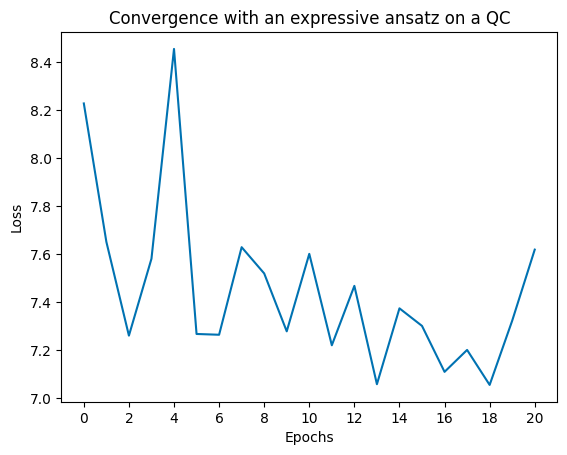

In [31]:
# plt.rcdefaults()
with plt.style.context('seaborn-colorblind'):
    plt.title("Convergence with an expressive ansatz on a QC")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(range(len(qc_expressive_results)), qc_expressive_results)
    plt.xticks(range(0,len(qc_expressive_results),2))
#     plt.savefig("qc_expressive.png", dpi=200)

In [8]:
def reverse_one_hot(x):
    return x[:,0]

In [55]:
# predictions = vqc.predict(Xtest)

f1_score(reverse_one_hot(Ytest), reverse_one_hot(predictions))

0.46153846153846156 F1 score for expressive setup executed on quantum computer.

In [56]:
# Cross entropy loss, COBYLA and circuit 14 from Sim et al. gives a score of 0.6 :(.
# 0.675 with cross entropy loss and AQGD and the same circuit as the first example. BOTH ENDED UP
# IN A BARREN PLATEAU!

We also perform a simulated run to see what we can expect without noise.

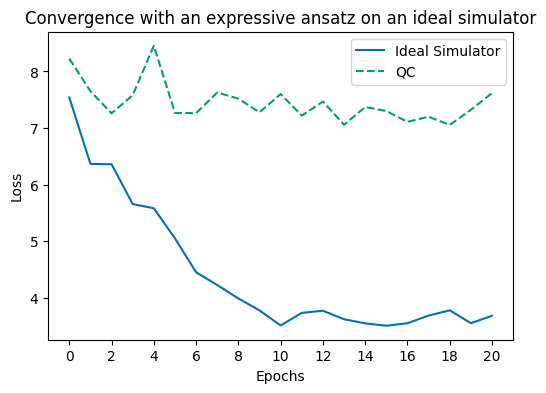

In [51]:
with plt.style.context('seaborn-colorblind'):
    plt.title("Convergence with an expressive ansatz on an ideal simulator")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(range(len(objective_func_vals)), objective_func_vals, label="Ideal Simulator")
    plt.plot(range(len(qc_expressive_results)), qc_expressive_results, '--', label="QC")
    plt.xticks(range(0,len(qc_expressive_results),2))
    plt.legend()
#     plt.savefig("expressive_comparison.png", dpi=200)

In [57]:
predictions = vqc.predict(Xtest)
f1_score(reverse_one_hot(Ytest), reverse_one_hot(predictions))
# 0.6410256410256411 f1 score with ideal simulator.

0.6410256410256411

Since we ended up in a barren plateau, we will now try much simpler conditions to see whether we can escape it. We now run the simple circuit for many qubtits to show that we get better results but also the variance in the gradient drops as we increase the number of qubits.

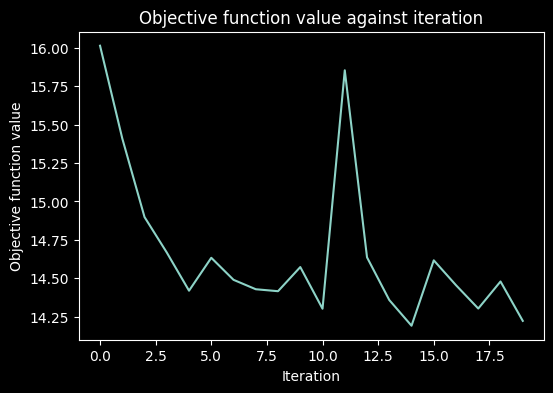

In [69]:
all_loss_values = [] # Store loss values for each iteration.
f1_scores = [] # Store respective f1 score for each iteration.

for i in range(2,10,2):
    objective_func_vals = [] # Callback function expects a list with this name.
    # Scale dimension and data size with ratio defined in paper.
    Xtrain, Ytrain, Xtest, Ytest = breast_cancer(training_size=i,
                                                test_size=40, n = i, one_hot=True)
    # Redefine circuit to match larger dimension size.
    feature_map = ZZFeatureMap(feature_dimension=i, reps=2, entanglement='linear')
    ansatz = TwoLocal(num_qubits=i, rotation_blocks='ry', entanglement_blocks='cx', 
                     entanglement='linear', reps=2)
    # Define our vqc.
    vqc = VQC(feature_map=feature_map,
              ansatz=ansatz,
              loss='cross_entropy',
              optimizer=L_BFGS_B(),
              quantum_instance=quantum_instance,
             callback=callback_graph)
    
    vqc.fit(Xtrain, Ytrain)
    
    predicitons = vqc.predict(Xtest) 
    
    all_loss_values.append(objective_func_vals)
    f1_scores.append(f1_score(reverse_one_hot(Ytest), reverse_one_hot(predicitons)))

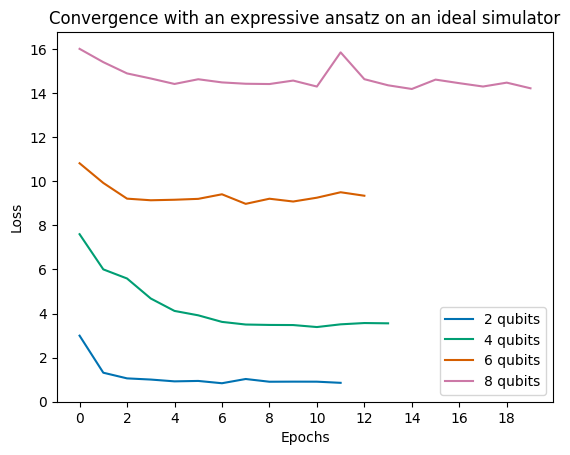

In [104]:
epochs = range(0,21,2)
labels = range(2,10,2)

with plt.style.context('seaborn-colorblind'):
    plt.title("Convergence with an expressive ansatz on an ideal simulator")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    for i in range(len(all_loss_values)):
        plt.plot(range(len(all_loss_values[i])), all_loss_values[i],
                 label="{} qubits".format(labels[i]))
        
    plt.xticks(range(0,len(all_loss_values[-1]),2)) # last run was the longest.
    plt.yticks(range(0,17,2))
    plt.legend()
#     plt.savefig("vanishing_loss.png", dpi=200)

[0.6486486486486486,
 0.5555555555555556,
 0.5238095238095238,
 0.5569620253164557] F1 scores for the above evaluations.

0.7 score with zzfeaturemap, reps=2, and TwoLocal with ry and cx blocks with reps=2 also. Could be a noise induced barren-plateau. Going to try reps=1 now. Better now, 0.725 but have that loss issue so can't see what is happening. Actually seems to be working, possibly, going to try without noise now. See: https://quantumcomputing.stackexchange.com/questions/15166/callback-function-in-vqe-do-not-return-the-intermediate-values-of-the-parameters for what was attempted to check if its working. We saw that print matched final list. Without noise 0.5 for reps=1. 0.725 with reps=2.

Random test with 2 and 4 qubits with reps=1, for simple configuration returns better results for 2 qubit. Worse for 4 qubits and reps=2. Same performance for 2 qubits.

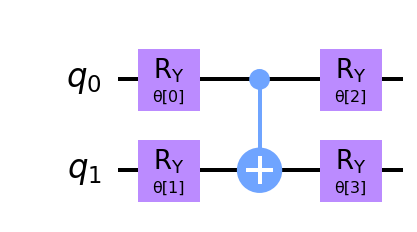

In [17]:
# For dissertaion.
qc = QuantumCircuit(2)
parameters = ParameterVector('θ', 4)
qc.ry(parameters[0], 0)
qc.ry(parameters[1], 1)
qc.cx(0,1)
qc.ry(parameters[2], 0)
qc.ry(parameters[3], 1)

qc.draw(output='mpl', scale=2, filename='simplecirc.png')